# Importing the Libraries

In [102]:
# !pip install --upgrade scikit-learn
# !pip install --upgrade imbalanced-learn
# !pip install xgboost

In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#Sampling
from collections import Counter
from imblearn.over_sampling import SMOTE

# Importing the dataset

In [104]:
dataset = pd.read_csv('bank-additional-full.csv', sep=';', quotechar='"')

In [105]:
dataset_copy = dataset.copy()

In [106]:
dataset.shape

(41188, 21)

#### Reordering the columns order as numerical to categorical

In [107]:
def change_column_type_object_to_categorical(df):
    object_columns = df.select_dtypes(include=['object']).columns.tolist()
    for column in object_columns:
        df[column] = pd.Categorical(df[column])

In [108]:
change_column_type_object_to_categorical(dataset_copy)

In [109]:
# Separate numerical and categorical columns
numerical_columns = dataset_copy.select_dtypes(include='number').columns.tolist()
categorical_columns = dataset_copy.select_dtypes(exclude='number').columns.tolist()

# Reorder the dataset as starting with numerical columns then categorical
new_order = numerical_columns + categorical_columns
dataset_copy = dataset_copy[new_order]

In [110]:
dataset_copy.dtypes

age                  int64
duration             int64
campaign             int64
pdays                int64
previous             int64
emp.var.rate       float64
cons.price.idx     float64
cons.conf.idx      float64
euribor3m          float64
nr.employed        float64
job               category
marital           category
education         category
default           category
housing           category
loan              category
contact           category
month             category
day_of_week       category
poutcome          category
y                 category
dtype: object

## Defining required functions:

In [111]:
def visualize_features(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, kde=True, color='skyblue')
    plt.title(f"Distribution of {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [112]:
def visualize_target_feature(df,column_name):
    plt.figure(figsize=(8, 5))
    sns.histplot(data=df, x=column_name, hue='y', multiple='stack', palette='Set2')
    plt.title(f"Distribution of 'y' within {column_name} Groups")
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

In [113]:
def visualize_outliers(df, column_name):
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x=column_name, color='skyblue')
    plt.title(f"Boxplot of {column_name} (with Outliers)")
    plt.xlabel(column_name)
    plt.tight_layout()
    plt.show()

In [114]:
def visualize(df,column_name):
    visualize_features(df,column_name)
    visualize_target_feature(df,column_name)
    visualize_outliers(df, column_name)

In [115]:
def remove_outliers_by_quantiles(df, column_name, lower_quantile=0.08, upper_quantile=0.92):
    lower_bound = df[column_name].quantile(lower_quantile)
    upper_bound = df[column_name].quantile(upper_quantile)
    df.drop(df[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)].index, inplace=True)

In [116]:
def extract_feature_by_thresholds(df,col_name,thresholds):
    labels = []
    for i in range(len(thresholds) - 1):
        label = f"{col_name}_({thresholds[i]}_{thresholds[i+1]}]"
        mask = (df[col_name] > thresholds[i]) & (df[col_name] <= thresholds[i+1])
        df.loc[mask, f'{col_name}_group'] = label
        labels.append(label)

In [117]:
def print_extract_feature_by_thresholds(df,col_name,thresholds):
    percentages = {}
    total_samples = len(df)
    for i in range(len(thresholds) - 1):
        lower_bound = thresholds[i]
        upper_bound = thresholds[i + 1]
        mask = (df[col_name] > lower_bound) & (df[col_name] <= upper_bound)
        count = df.loc[mask].shape[0]
        percentage = (count / total_samples)
        rounded_percentage = round(percentage, 4)
        print(f"({lower_bound}_{upper_bound}] = {rounded_percentage}, samples:{count}")

In [118]:
def calculate_success_rate(df, feature_column, target_column, lower_bound,upper_bound):
    # Filter the DataFrame for the specific condition
    filtered_df = df[(df[feature_column] >= lower_bound) & (df[feature_column] <= upper_bound)].copy()
    # Group by the feature column and calculate the rate of 'yes' for each unique value
    grouped = filtered_df.groupby(feature_column)[target_column].apply(lambda x: (x == 'yes').mean())
    success_rate = grouped.mean()
    return grouped, success_rate

In [119]:
def generate_start_end_threshold(df, col_name, increment_range):
    start = df[col_name].min() - (df[col_name].min())%increment_range
    end = df[col_name].max() - (df[col_name].max())%increment_range + increment_range
    return start, end

In [120]:
def generate_threshold(df,col_name,increment_range):
    start, end = generate_start_end_threshold(df,col_name,increment_range)
    thresholds = []
    threshold = start
    while threshold <= end:
        thresholds.append(threshold)
        threshold += increment_range
    return thresholds

In [121]:
def correlation_heatmap(df,numerical_col):
    ## taking from https://github.com/bowcai/bank-analysis/blob/main/bank-analysis.ipynb
    fig= plt.figure(figsize=(8,8))

    corr = df[numerical_col].corr()
    mask = np.triu(df[numerical_col].corr())

    axes = fig.add_axes([0, 0, 1, 1])
    sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
                linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

# Data Visualization

In [122]:
# for col in dataset_copy.columns:
#     visualize_features(dataset_copy,col)

# Handling outliers

In [123]:
numerical_columns

['age',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed']

In [124]:
for col_name in numerical_columns:
    remove_outliers_by_quantiles(dataset_copy,col_name)

# Handling missing values

In [125]:
# Only categorical features has missing values
print(dataset_copy[categorical_columns].isin(['unknown']).sum())

job             153
marital          33
education       752
default        4830
housing         468
loan            468
contact           0
month             0
day_of_week       0
poutcome          0
y                 0
dtype: int64


In [126]:
# Replacing the "unknown" with np.nan
dataset_copy.replace('unknown', np.nan, inplace=True)
dataset_copy.fillna(dataset_copy.mode().iloc[0], inplace=True)

# Feature Extraction:

##### 1-) "Age"

In [127]:
age_threshold = generate_threshold(dataset_copy,'age',5)
print(age_threshold)

[25, 30, 35, 40, 45, 50, 55, 60]


In [128]:
print_extract_feature_by_thresholds(dataset_copy,'age',age_threshold)

(25_30] = 0.1113, samples:2184
(30_35] = 0.2554, samples:5011
(35_40] = 0.2112, samples:4144
(40_45] = 0.1613, samples:3165
(45_50] = 0.1363, samples:2674
(50_55] = 0.1051, samples:2062
(55_60] = 0.0193, samples:379


In [129]:
extract_feature_by_thresholds(dataset_copy,'age',age_threshold)

##### 2-) "duration"

In [130]:
duration_threshold = generate_threshold(dataset_copy,'duration',100)
print(duration_threshold)

[0, 100, 200, 300, 400, 500, 600, 700]


In [131]:
print_extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)

(0_100] = 0.2052, samples:4025
(100_200] = 0.3734, samples:7325
(200_300] = 0.2052, samples:4025
(300_400] = 0.1136, samples:2229
(400_500] = 0.0595, samples:1167
(500_600] = 0.0395, samples:775
(600_700] = 0.0037, samples:73


In [132]:
extract_feature_by_thresholds(dataset_copy,'duration',duration_threshold)

##### 3-) "pdays"

In [133]:
dataset_copy['pdays_group'] = dataset_copy['pdays']
dataset_copy.loc[dataset_copy['pdays'] <= 100, 'pdays_group'] = 0
dataset_copy.loc[dataset_copy['pdays'] > 100, 'pdays_group'] = 1

In [134]:
print(dataset_copy['pdays_group'].value_counts())

pdays_group
1    19619
Name: count, dtype: int64


##### 4-) "emp.var.rate"

In [135]:
dataset_copy['emp.var.rate_sign'] = dataset_copy['emp.var.rate']
dataset_copy.loc[dataset_copy['emp.var.rate'] < 0, 'emp.var.rate_sign'] = -1    # negative employment variation rate
dataset_copy.loc[dataset_copy['emp.var.rate'] > 0, 'emp.var.rate_sign'] = 1     # positive employment variation rate

In [136]:
print(dataset_copy['emp.var.rate_sign'].value_counts())

emp.var.rate_sign
 1.0    14526
-1.0     5093
Name: count, dtype: int64


##### 5-) "cons.conf.idx"

In [137]:
cons_conf_idx_threshold = generate_threshold(dataset_copy,'cons.conf.idx',5)
print(cons_conf_idx_threshold)

[-50.0, -45.0, -40.0, -35.0]


In [138]:
print_extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

(-50.0_-45.0] = 0.1148, samples:2252
(-45.0_-40.0] = 0.4605, samples:9035
(-40.0_-35.0] = 0.4247, samples:8332


In [139]:
extract_feature_by_thresholds(dataset_copy,'cons.conf.idx',cons_conf_idx_threshold)

# Encoding features:

In [140]:
print(categorical_columns)

['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']


In [141]:
label_encoded_features = ['age_group','duration_group','cons.conf.idx_group',
                          'education','default','housing','loan','month',
                          'day_of_week','poutcome','marital','contact','y']
onehot_encoded_features = ['job']

In [142]:
ohe = OneHotEncoder(dtype='int32')
label_encoder = LabelEncoder()

for col in onehot_encoded_features:
    transformed = ohe.fit_transform(dataset_copy[[col]])
    dataset_copy[ohe.categories_[0]] = transformed.toarray()

for column in label_encoded_features:
    dataset_copy[column] = label_encoder.fit_transform(dataset_copy[column])

In [143]:
dataset_copy.dtypes

age                       int64
duration                  int64
campaign                  int64
pdays                     int64
previous                  int64
emp.var.rate            float64
cons.price.idx          float64
cons.conf.idx           float64
euribor3m               float64
nr.employed             float64
job                    category
marital                   int32
education                 int32
default                   int32
housing                   int32
loan                      int32
contact                   int32
month                     int32
day_of_week               int32
poutcome                  int32
y                         int32
age_group                 int32
duration_group            int32
pdays_group               int64
emp.var.rate_sign       float64
cons.conf.idx_group       int32
admin.                    int32
blue-collar               int32
entrepreneur              int32
housemaid                 int32
management                int32
retired 

# Feature Reduction:

<Axes: >

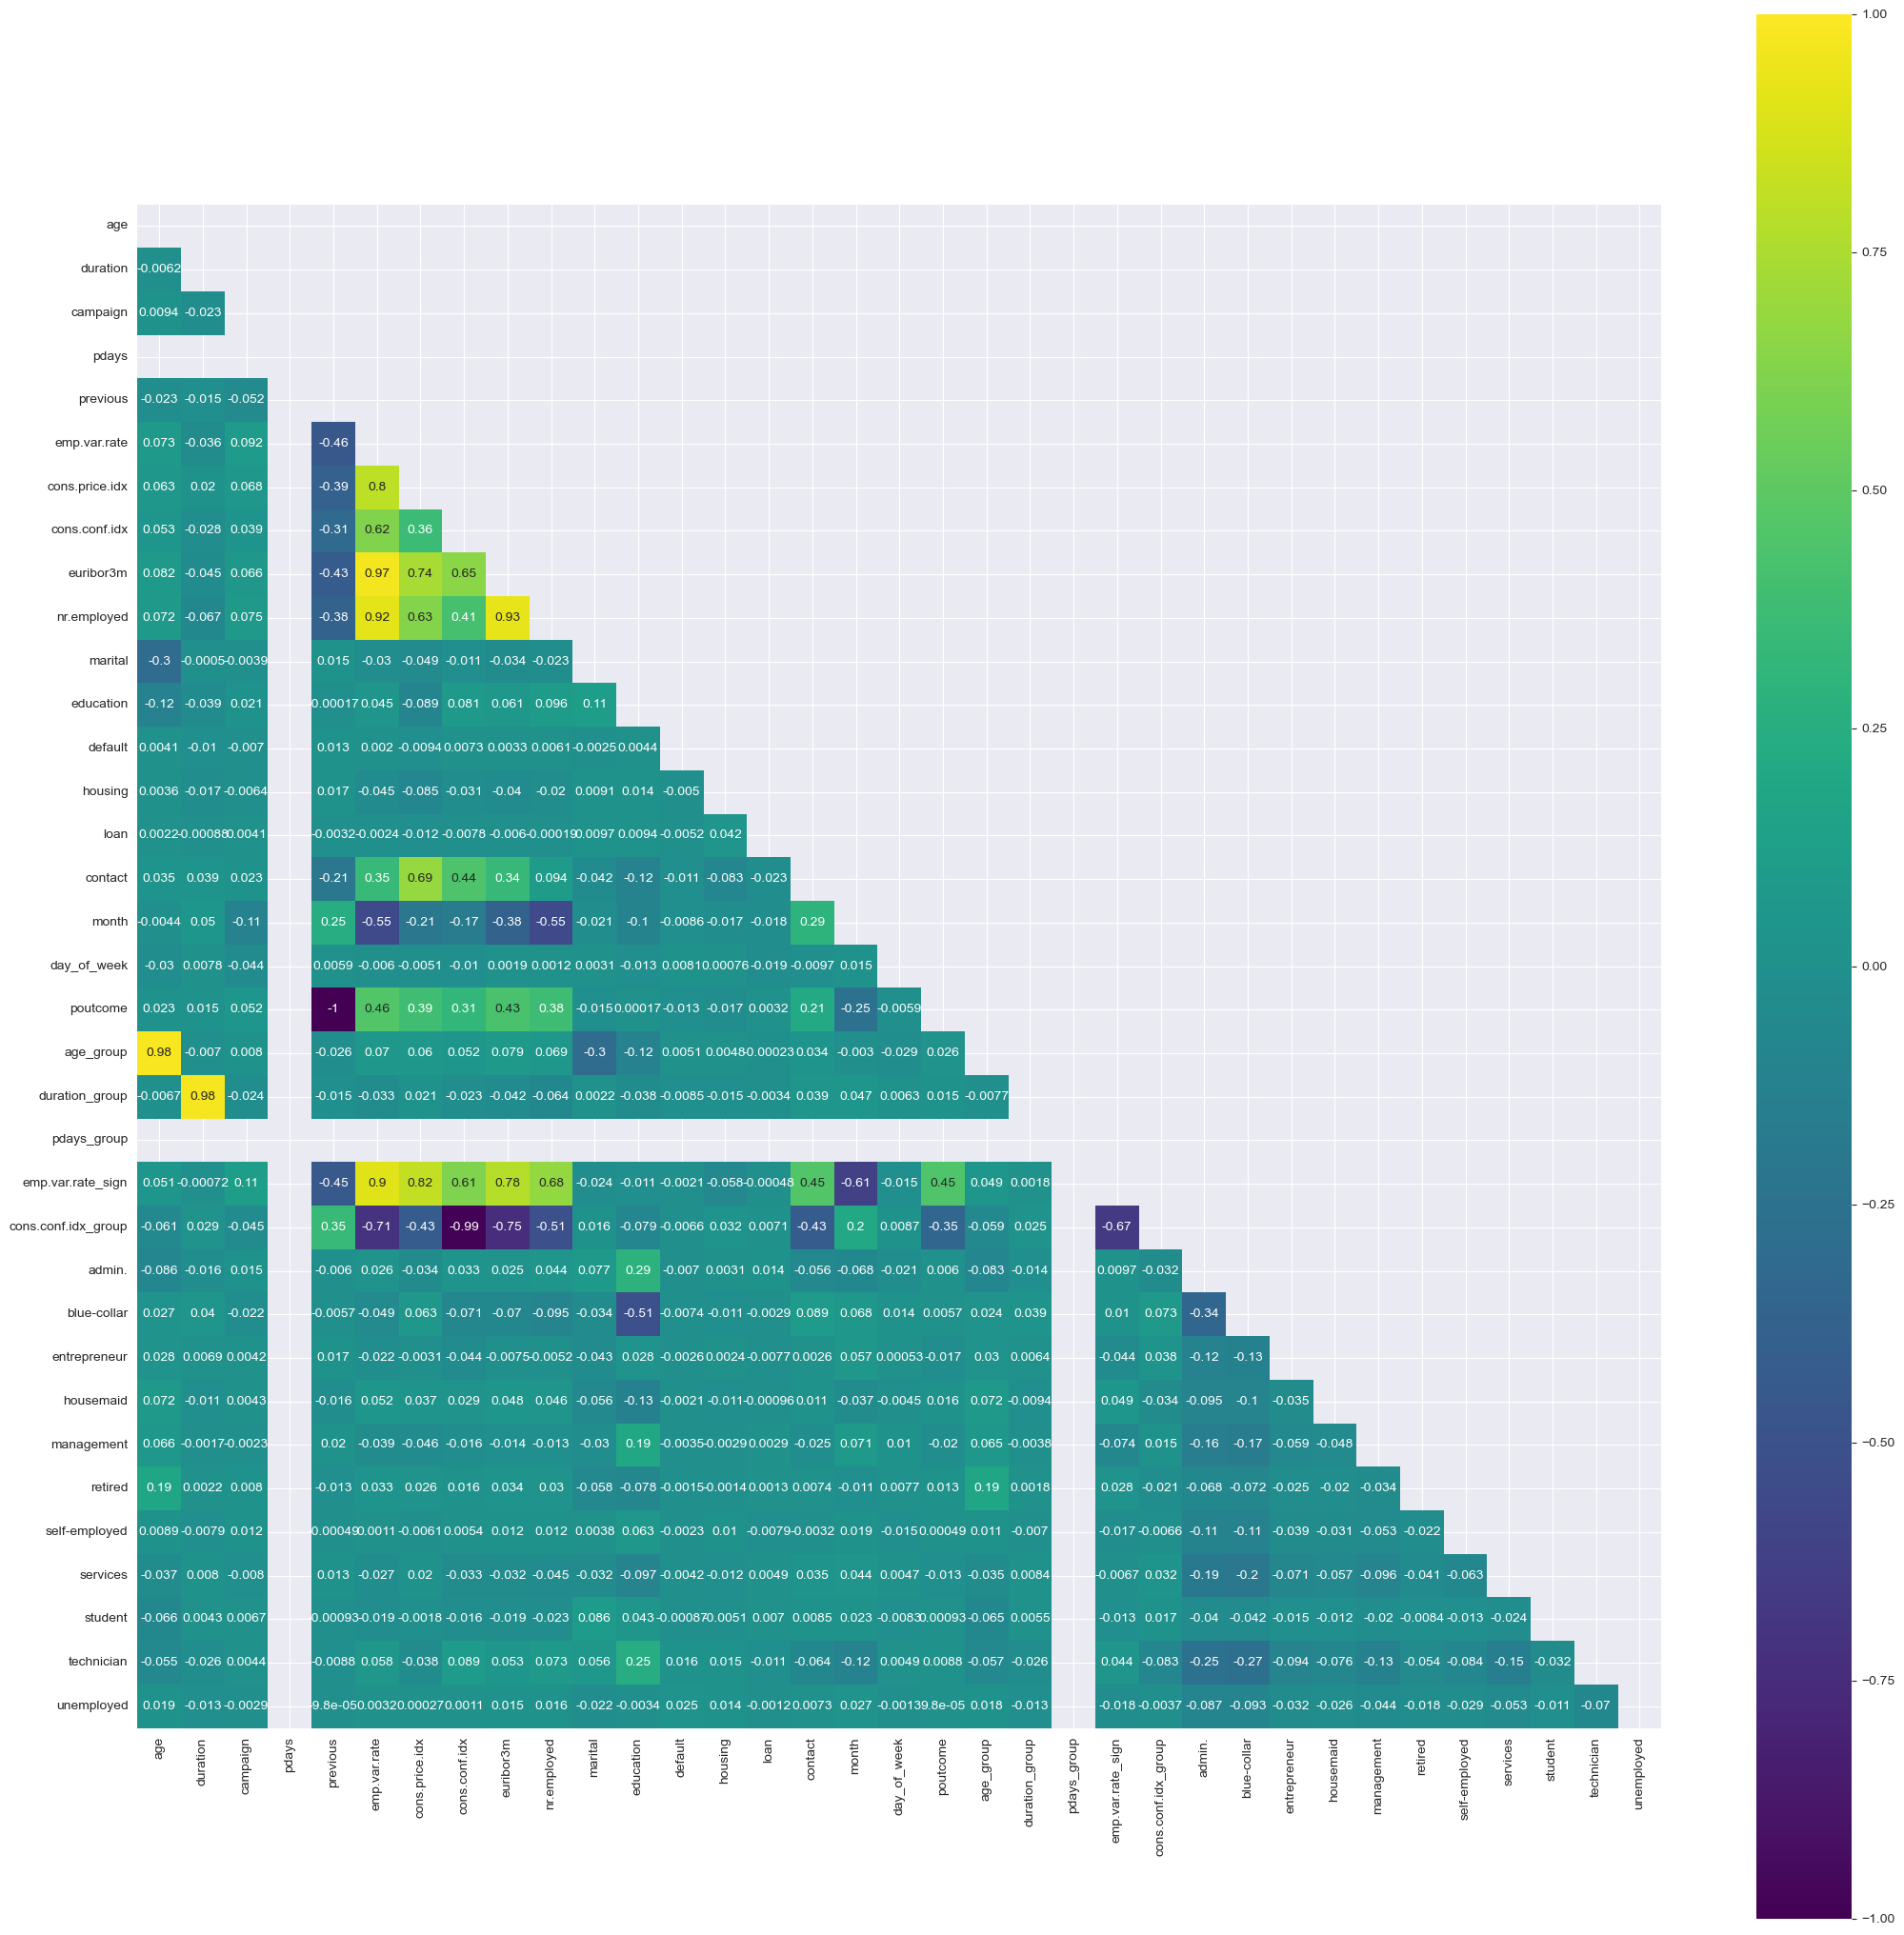

In [144]:
fig= plt.figure(figsize=(20,20))
df = dataset_copy.drop(['y','job'], axis=1)
corr = df.corr()
mask = np.triu(df.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [145]:
# selected_features = ['age_group','duration_group','campaign','previous','emp.var.rate_sign','cons.conf.idx_group',
#                      'marital','default','housing','loan','contact','month','day_of_week','admin.', 'blue-collar', 'entrepreneur',
#                      'housemaid', 'management', 'retired', 'self-employed', 'services',
#                      'student', 'technician', 'unemployed','y']
# dataset_selected = dataset_copy[selected_features].copy()

In [146]:
# Remove the one of the high correlated features
dataset_selected= dataset_copy.drop(['age','duration','pdays','cons.price.idx','job','poutcome','emp.var.rate','cons.conf.idx', 'euribor3m', 'nr.employed'], axis=1)
numerical_columns = dataset_selected.select_dtypes(include='number').columns.tolist()

<Axes: >

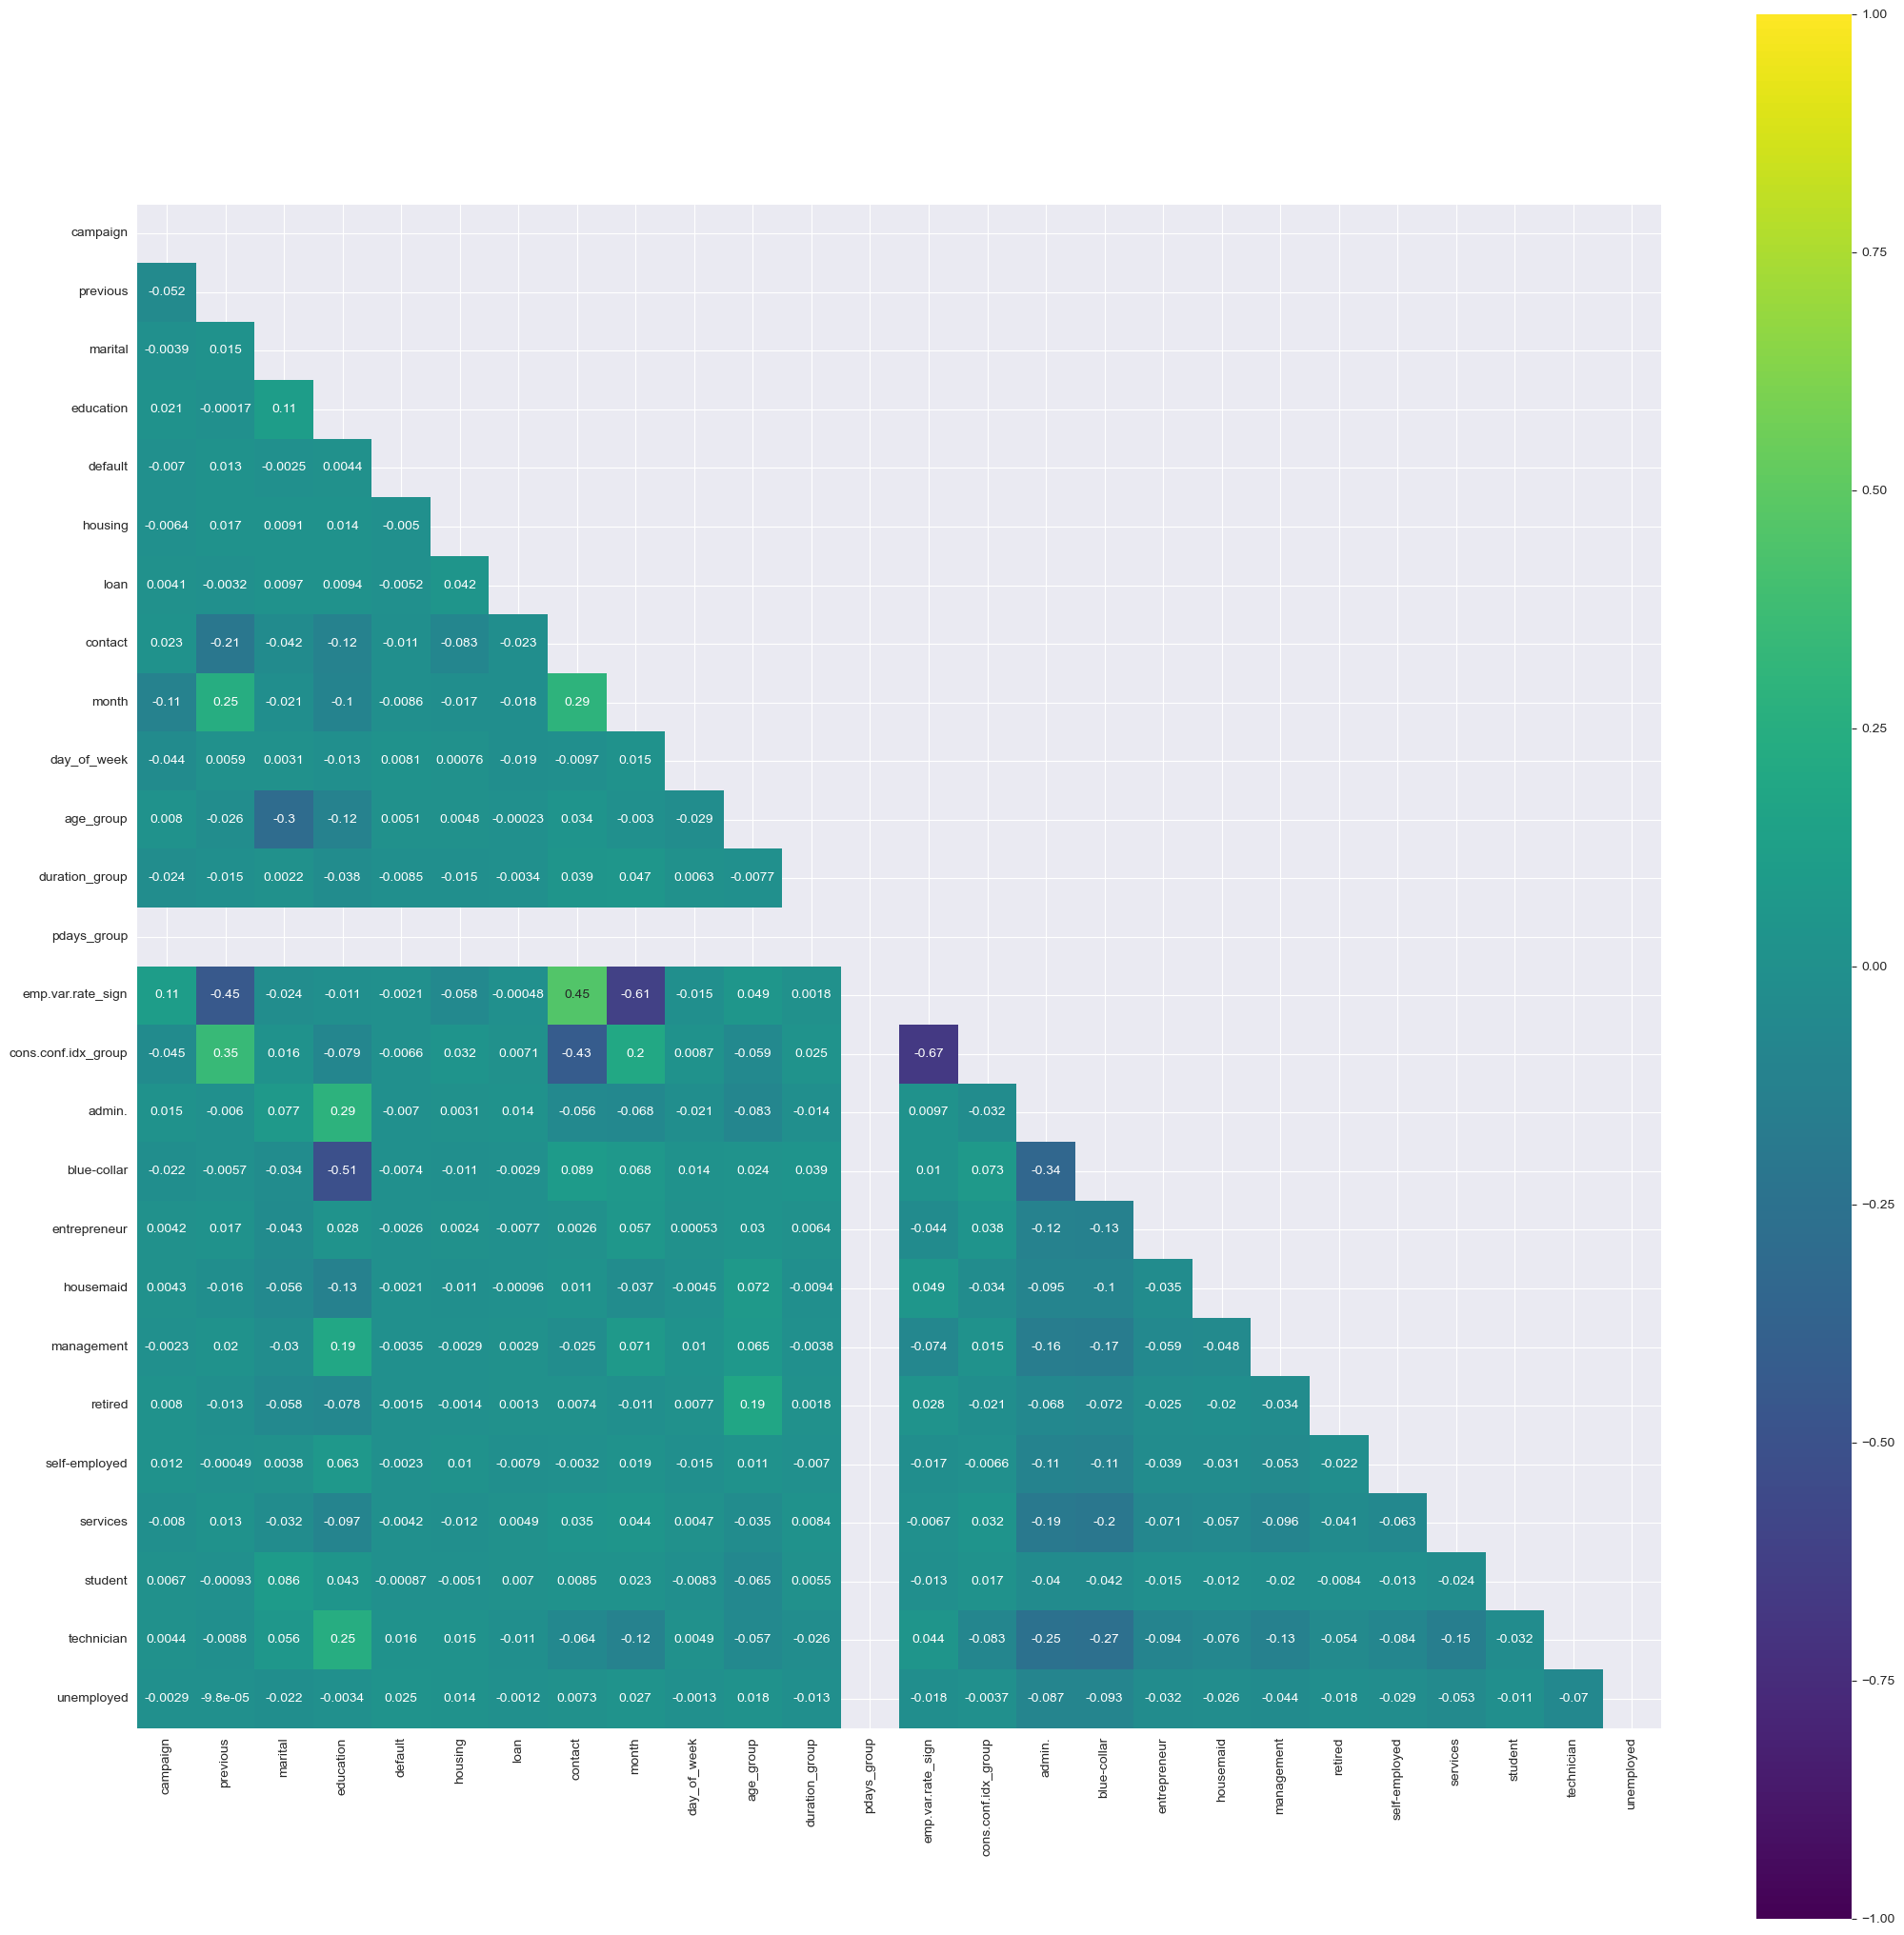

In [147]:
fig= plt.figure(figsize=(20,20))
df = dataset_selected.drop(['y'], axis=1)
corr = df.corr()
mask = np.triu(df.corr())

axes = fig.add_axes([0, 0, 1, 1])
sns.heatmap(corr, annot=True, mask=mask, square=True,fmt='.2g',vmin=-1, vmax=1, center= 0, cmap='viridis',
            linecolor='white', cbar_kws= {'orientation': 'vertical'}, ax=axes)

In [148]:
dataset_selected.columns

Index(['campaign', 'previous', 'marital', 'education', 'default', 'housing',
       'loan', 'contact', 'month', 'day_of_week', 'y', 'age_group',
       'duration_group', 'pdays_group', 'emp.var.rate_sign',
       'cons.conf.idx_group', 'admin.', 'blue-collar', 'entrepreneur',
       'housemaid', 'management', 'retired', 'self-employed', 'services',
       'student', 'technician', 'unemployed'],
      dtype='object')

In [149]:
dataset_selected.dtypes

campaign                 int64
previous                 int64
marital                  int32
education                int32
default                  int32
housing                  int32
loan                     int32
contact                  int32
month                    int32
day_of_week              int32
y                        int32
age_group                int32
duration_group           int32
pdays_group              int64
emp.var.rate_sign      float64
cons.conf.idx_group      int32
admin.                   int32
blue-collar              int32
entrepreneur             int32
housemaid                int32
management               int32
retired                  int32
self-employed            int32
services                 int32
student                  int32
technician               int32
unemployed               int32
dtype: object

# Feature Sampling:

In [150]:
dataset_copy.shape

(19619, 37)

In [151]:
X = dataset_selected.drop(['y'], axis=1)
y = dataset_selected['y']

In [152]:
X.head()

,campaign,previous,marital,education,default,housing,loan,contact,month,day_of_week,...,blue-collar,entrepreneur,housemaid,management,retired,self-employed,services,student,technician,unemployed
0,1,0,1,0,0,0,0,1,3,1,...,0,0,1,0,0,0,0,0,0,0
2,1,0,1,3,0,1,0,1,3,1,...,0,0,0,0,0,0,1,0,0,0
3,1,0,1,1,0,0,0,1,3,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,1,3,0,0,1,1,3,1,...,0,0,0,0,0,0,1,0,0,0
5,1,0,1,2,0,0,0,1,3,1,...,0,0,0,0,0,0,1,0,0,0


In [153]:
counter = Counter(y)
print(f"Before oversampling:{counter}")

oversampling = SMOTE()
X_oversampled, y_smote_sampler = oversampling.fit_resample(X, y)

counter = Counter(y_smote_sampler)
print(f"After oversampling:{counter}")

Before oversampling:Counter({0: 19312, 1: 307})
After oversampling:Counter({0: 19312, 1: 19312})


# Feature Transformation

In [154]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# Apply Min_Max scaler
scaler_minmax = MinMaxScaler()
scaler_standard = StandardScaler()

X_minmax = scaler_minmax.fit_transform(X_oversampled)
X_standard = scaler_standard.fit_transform(X_oversampled)

# Feature Selection:

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, RFE, mutual_info_classif as MIC
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score, recall_score, precision_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [156]:
# Prepare dataset for RFE (Recursive Feature Elimination)
def func_RFE_X_rfe(param_X,param_y):
    model = LogisticRegression(max_iter=1000)
    rfe = RFE(model, step = 4)
    fit = rfe.fit(param_X,param_y)
    selected_features = fit.support_
    X_rfe = param_X[:, selected_features]
    print("Num Features: %s" % (fit.n_features_))
    print("Selected Features: %s" % (fit.support_))
    print("Feature Ranking: %s" % (fit.ranking_))
    return X_rfe

In [157]:
# Prepare dataset for SelectKBest (score_func=chi2)
def func_SelectKBest_X_chi2(param_X,param_y):
    test = SelectKBest(score_func=chi2, k=23)
    fit = test.fit(param_X,param_y)
    X_chi2 = fit.transform(param_X)
    return X_chi2

In [158]:
# Prepare dataset for Ridge
def func_Ridge_X_ridge(param_X,param_y):
    ridge = Ridge(alpha=1.0)
    ridge.fit(param_X,param_y)
    best_alpha = ridge.alpha
    ridge_model = Ridge(alpha=best_alpha)
    ridge_model.fit(param_X,param_y)
    selector = SelectFromModel(ridge_model)
    X_ridge = selector.transform(param_X)
    return X_ridge

In [159]:
# Prepare dataset for MIC (mutual_info_classif)
def func_MIC_X_mic(param_X,param_y):
    mi_scores = MIC(param_X,param_y)
    mi_score_selected_index = np.where(mi_scores <0.2)[0]
    X_mic = param_X[:,mi_score_selected_index]
    mi_scores
    return X_mic

In [192]:
def print_scores(accuracy_score, recall_score, precision_score, f1_score, model_name):
    print(f"accuracy_{model_name}:{accuracy_score:10.4f}\t"
          f"recall {model_name}:{recall_score:10.4f}\t"
          f"precision {model_name}:{precision_score:10.4f}\t"
          f"f1_score_{model_name}:{f1_score:10.4f}")

In [161]:
def predict_scores(model, x_test, y_test):
    score           = model.score(x_test,y_test)
    y_predict       = model.predict(x_test)
    score_recall    = recall_score(y_predict, y_test)
    score_precision = precision_score(y_predict, y_test)
    f1_scr          = f1_score(y_test, y_predict)
    return score,score_recall,score_precision, f1_scr

In [162]:
def func_Calculate_Model_Scores(param_x,param_y, X_chi2, X_rfe, X_ridge, X_mic):
    # Split the data into training and testing sets
    
    X_train, X_test, y_train, y_test                     = train_test_split(param_x,param_y, random_state=0, stratify=param_y)
    X_train_chi2, X_test_chi2, y_train_chi2, y_test_chi2 = train_test_split(X_chi2, param_y, random_state=0, stratify=param_y)
    X_train_RFE, X_test_RFE, y_train_RFE, y_test_RFE     = train_test_split(X_rfe, param_y, random_state=0, stratify=param_y)
    X_train_Ridge, X_test_Ridge, y_train_Ridge, y_test_Ridge = train_test_split(X_ridge, param_y, random_state=0, stratify=param_y)
    X_train_MIC, X_test_MIC, y_train_MIC, y_test_MIC     = train_test_split(X_mic, param_y, random_state=0, stratify=param_y)
    RFC = RandomForestClassifier()

    # Compare results with Random Forest Classifier
    model_default = RFC.fit(X_train,y_train)
    score_default, recall_score_default, precision_score_default, f1_score_default = predict_scores(model_default,X_test,y_test) 

    model_MIC = RFC.fit(X_train_MIC,y_train_MIC)
    score_MIC, recall_score_MIC, precision_score_MIC, f1_score_MIC = predict_scores(model_MIC,X_test_MIC,y_test_MIC)

    model_chi2 = RFC.fit(X_train_chi2,y_train_chi2)
    score_chi2, recall_score_chi2, precision_score_chi2, f1_score_chi2 = predict_scores(model_chi2,X_test_chi2,y_test_chi2)

    model_RFE = RFC.fit(X_train_RFE,y_train_RFE)
    score_rfe, recall_score_rfe, precision_score_rfe, f1_score_rfe = predict_scores(model_RFE,X_test_RFE,y_test_RFE)

    model_Ridge = RFC.fit(X_train_Ridge,y_train_Ridge)
    score_ridge, recall_score_ridge, precision_score_ridge, f1_score_ridge = predict_scores(model_Ridge,X_test_Ridge,y_test_Ridge)

    #---------------------------------------------------------------------------------
    print_scores(score_MIC, recall_score_MIC, precision_score_MIC, f1_score_MIC, "MIC")
    print_scores(score_rfe, recall_score_rfe, precision_score_rfe, f1_score_rfe, "RFE")
    print_scores(score_chi2, recall_score_chi2, precision_score_chi2, f1_score_chi2, "chi2")
    print_scores(score_ridge, recall_score_ridge, precision_score_ridge, f1_score_ridge, "Ridge")
    print_scores(score_default, recall_score_default, precision_score_default, f1_score_default, "default")

In [163]:
print("Scores for minmax scaler:")
x_chi2 = func_SelectKBest_X_chi2(X_minmax,y_smote_sampler)
x_rfe = func_Ridge_X_ridge(X_minmax,y_smote_sampler)
x_ridge = func_Ridge_X_ridge(X_minmax,y_smote_sampler)
x_mic = func_MIC_X_mic(X_minmax,y_smote_sampler)

func_Calculate_Model_Scores(X_minmax, y_smote_sampler, x_chi2, x_rfe, x_ridge, x_mic)

Scores for minmax scaler:
score_MIC:0.9788recall score_MIC:0.9726precision score_MIC:0.9853f1 score_MIC:0.9789
score_RFE:0.9245recall score_RFE:0.9080precision score_RFE:0.9447f1 score_RFE:0.9260
score_chi2:0.9867recall score_chi2:0.9822precision score_chi2:0.9915f1 score_chi2:0.9868
score_Ridge:0.9244recall score_Ridge:0.9078precision score_Ridge:0.9447f1 score_Ridge:0.9259
score_default:0.9901recall score_default:0.9872precision score_default:0.9930f1 score_default:0.9901


# Cross-Validation

In [164]:
# from sklearn.model_selection import cross_val_score
# from sklearn.svm import SVC
# X_train, X_test, y_train, y_test   = train_test_split(X_minmax,y_smote_sampler, random_state=0, stratify=y_smote_sampler)
# 
# model = SVC(kernel= 'rbf', random_state=0)
# model.fit(X_train,y_train)
# accuracy = cross_val_score(estimator= model, X=X_train, y = y_train, cv=10)

In [165]:
# from sklearn.model_selection import GridSearchCV
# 
# parameters = [{'C': [0.5,1,10], 'kernel': ['linear']},
#               {'C': [0.5,1,10], 'kernel': ['rbf'], 'gamma': [0.1, 0.5, 1]}]
# grid_search = GridSearchCV(estimator= model,
#                            param_grid= parameters,
#                            scoring= 'accuracy',
#                            cv = 10,
#                            n_jobs= -1)
# grid_search.fit(X_train,y_train)
# best_accuracy = grid_search.best_score_
# best_parameters = grid_search.best_params_

In [166]:
# print("Best accuracy:{:.2f}".format(best_accuracy*100))
# print("Best parameters:",best_parameters)

# Splitting the dataset into the Training set and Test set

In [167]:
X_train, X_test, y_train, y_test   = train_test_split(X_oversampled,y_smote_sampler, random_state=42)

# Feature Scaling

In [168]:
sc = StandardScaler()
X_train_ml = sc.fit_transform(X_train)
X_test_ml = sc.transform(X_test)

# ML Algorithms Implementation:

In [169]:
def plot_confusion_matrix(test_y, y_pred, model_name):
    # Generate confusion matrix
    cm = confusion_matrix(test_y, y_pred)

    # Create a custom colormap for better readability
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Create a heatmap with customized colors and annotations
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, cmap=cmap, fmt='g', cbar=False)

    # Set labels, title, and layout
    plt.title(f'Confusion Matrix of {model_name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=8)
    plt.ylabel('Actual', fontsize=8)
    plt.xticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
    plt.yticks(ticks=[0.5, 1.5], labels=['Negative', 'Positive'])
    plt.tight_layout()

    plt.show()

In [170]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

def draw_AUC_graph(train_X, test_X, train_y, test_y, model, model_name):
    # Get predicted probabilities for the positive class for both train and test sets
    y_train_probs = model.predict_proba(train_X)[:, 1]
    y_test_probs = model.predict_proba(test_X)[:, 1]

    # Compute ROC curve and ROC AUC for both train and test sets
    fpr_train, tpr_train, _ = roc_curve(train_y, y_train_probs)
    fpr_test, tpr_test, _ = roc_curve(test_y, y_test_probs)

    roc_auc_train = roc_auc_score(train_y, y_train_probs)
    roc_auc_test = roc_auc_score(test_y, y_test_probs)

    # Plot ROC curves for both train and test sets, display AUC values as labels
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_train, tpr_train, label=f'Train ROC Curve (AUC = {roc_auc_train:.2f})')
    plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
    plt.plot([0, 1], [0, 1], 'r--', label='Random Guessing')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
    plt.legend()
    plt.show()

    print(f"Train AUC: {roc_auc_train:.4f}")
    print(f"Test AUC: {roc_auc_test:.4f}")

# Training the Classification models on the Training set

### Implementing Decision Tree Classification model

In [171]:
# Training the Decision Tree Classification model:
model_dtc = DecisionTreeClassifier(criterion='entropy', random_state=42)
model_dtc.fit(X_train, y_train)
y_pred_dtc = model_dtc.predict(X_test)

### Implementing K-Nearest Neighbors (K-NN) model

In [172]:
# Training the K-NN model:
model_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
model_knn.fit(X_train, y_train)
y_pred_knn = model_knn.predict(X_test)

### Implementing Kernel SVM model

In [173]:
# Training the Kernel SVM:
model_svc = SVC(kernel = 'rbf', random_state = 42, probability=True)
model_svc.fit(X_train, y_train)
y_pred_svc = model_svc.predict(X_test)

### Implementing Logistic Regression model

In [174]:
# Training the Logistic Regression model
model_logistic_regression = LogisticRegression(random_state = 42, max_iter=30000)
model_logistic_regression.fit(X_train, y_train)
y_pred_lr = model_logistic_regression.predict(X_test)

### Implementing Random Forest Classification model

In [175]:
# Training the Random Forest Classification model
model_rfc = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
model_rfc.fit(X_train, y_train)
y_pred_rfc = model_rfc.predict(X_test)

### Implementing Support Vector Machine (SVM) model:

In [176]:
# Training the SVM model:
model_svm = SVC(kernel = 'linear', random_state = 42, probability=True)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)

# Visualizing the ROC curve with AUC values

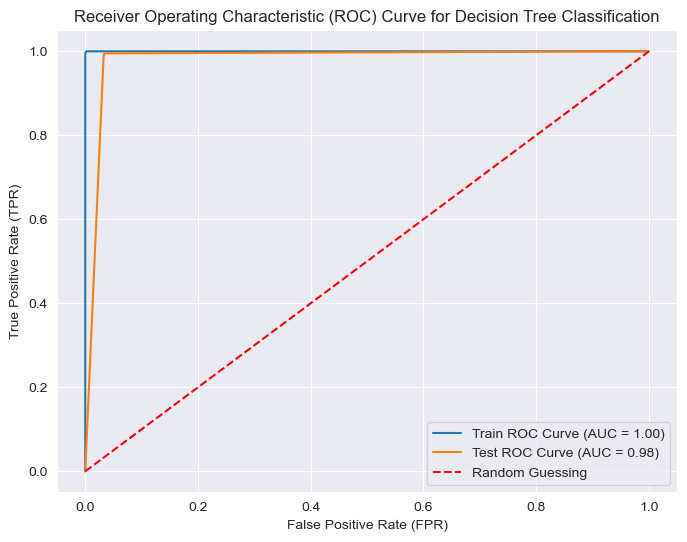

Train AUC: 1.0000
Test AUC: 0.9811


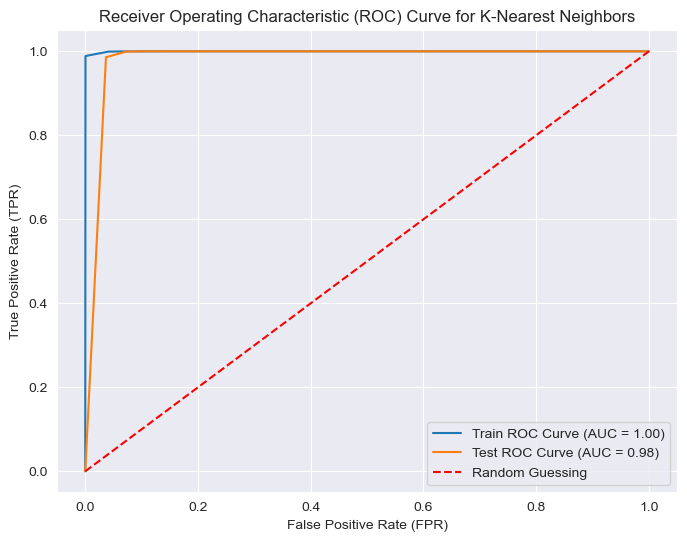

Train AUC: 0.9995
Test AUC: 0.9811


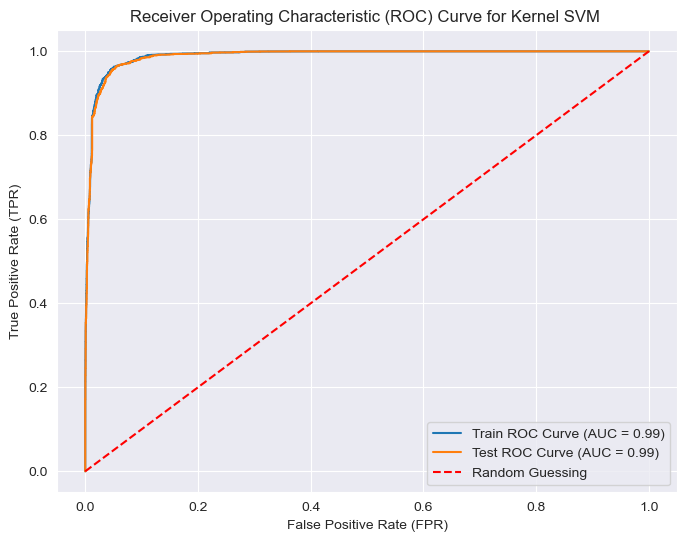

Train AUC: 0.9896
Test AUC: 0.9889


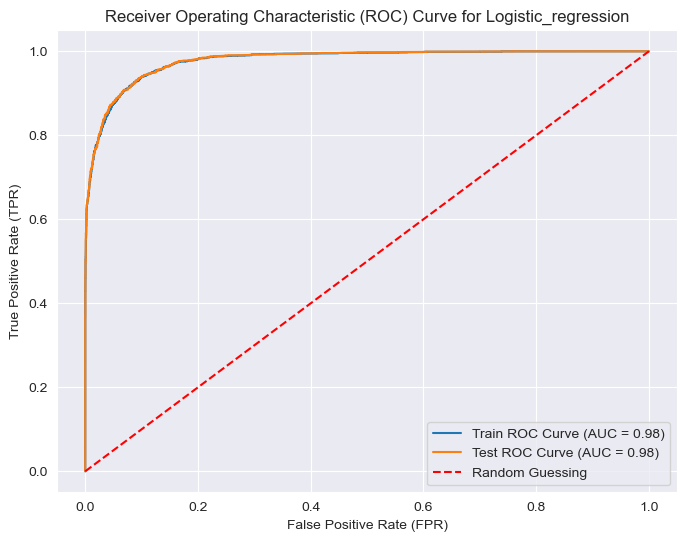

Train AUC: 0.9780
Test AUC: 0.9786


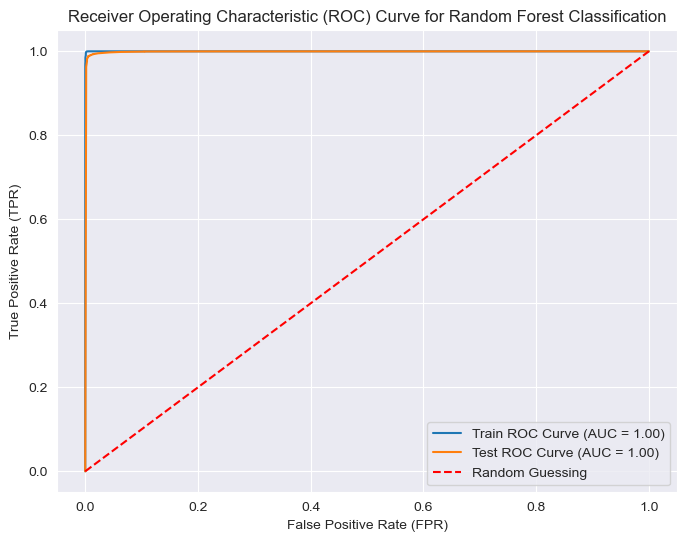

Train AUC: 1.0000
Test AUC: 0.9987


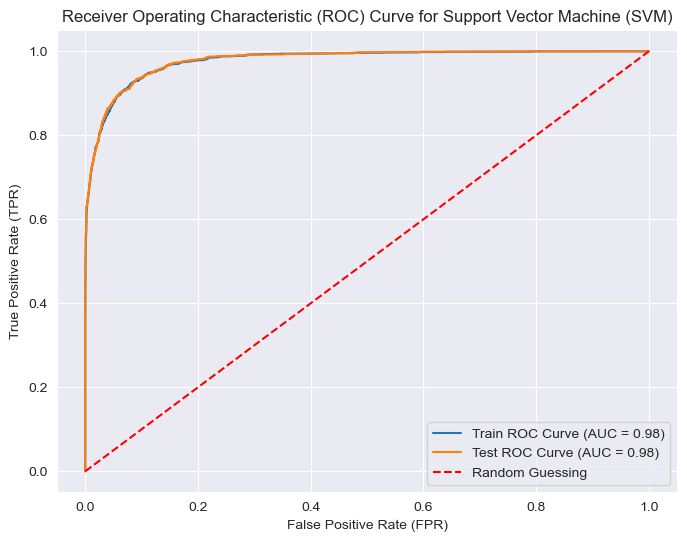

Train AUC: 0.9779
Test AUC: 0.9785


In [177]:
draw_AUC_graph(X_train,X_test,y_train,y_test,model_dtc, "Decision Tree Classification")
draw_AUC_graph(X_train,X_test,y_train,y_test,model_knn, "K-Nearest Neighbors")
draw_AUC_graph(X_train,X_test,y_train,y_test,model_svc, "Kernel SVM ")
draw_AUC_graph(X_train,X_test,y_train,y_test,model_logistic_regression, "Logistic_regression")
draw_AUC_graph(X_train,X_test,y_train,y_test,model_rfc, "Random Forest Classification")
draw_AUC_graph(X_train,X_test,y_train,y_test,model_svm, "Support Vector Machine (SVM)")

# Visualizing the Confusion Matrix

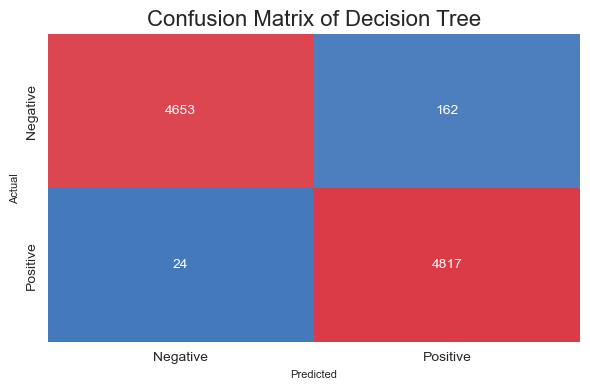

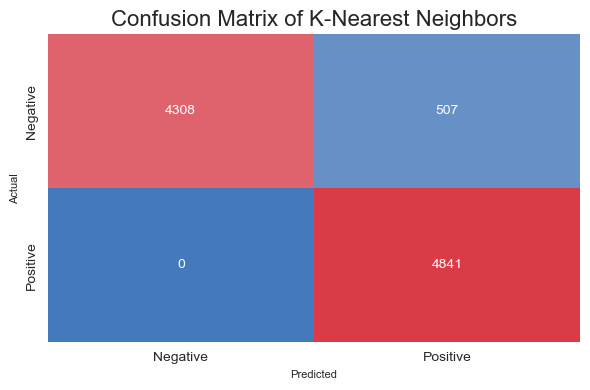

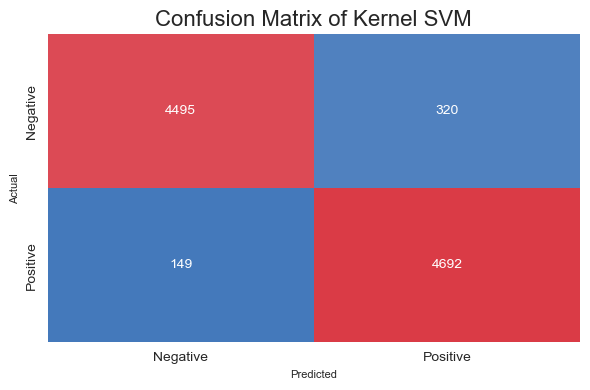

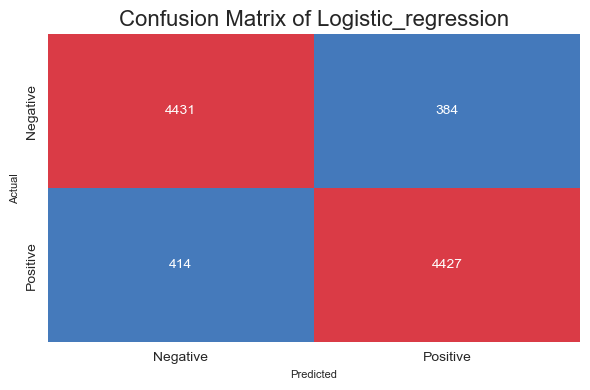

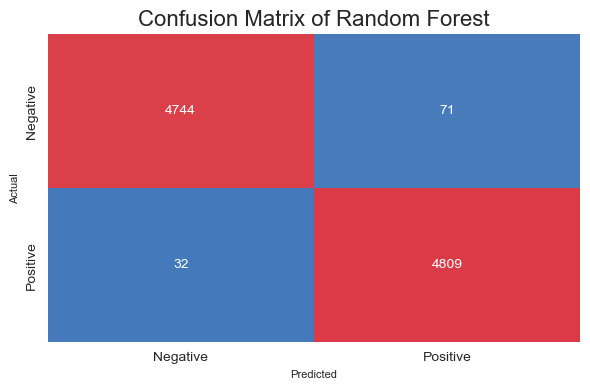

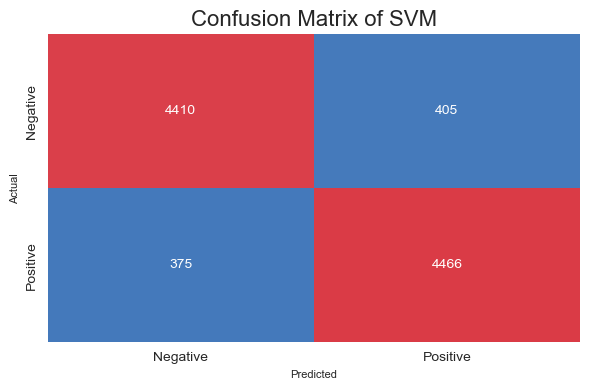

In [178]:
plot_confusion_matrix(y_test,y_pred_dtc, "Decision Tree")
plot_confusion_matrix(y_test,y_pred_knn, "K-Nearest Neighbors")
plot_confusion_matrix(y_test,y_pred_svc, "Kernel SVM")
plot_confusion_matrix(y_test,y_pred_lr, "Logistic_regression")
plot_confusion_matrix(y_test,y_pred_rfc, "Random Forest")
plot_confusion_matrix(y_test,y_pred_svm, "SVM")

# Printing the accuracy,recall,precision,f1 scores:

In [179]:
score_dtc, recall_score_dtc, precision_score_dtc, f1_score_dtc = predict_scores(model_dtc,X_test,y_test)
score_knn, recall_score_knn, precision_score_knn, f1_score_knn = predict_scores(model_knn,X_test,y_test)
score_svc, recall_score_svc, precision_score_svc, f1_score_svc = predict_scores(model_svc,X_test,y_test)
score_lr, recall_score_lr, precision_score_lr, f1_score_lr     = predict_scores(model_logistic_regression,X_test,y_test)
score_rfc, recall_score_rfc, precision_score_rfc, f1_score_rfc = predict_scores(model_rfc,X_test,y_test)
score_svm, recall_score_svm, precision_score_svm, f1_score_svm = predict_scores(model_svm,X_test,y_test)

In [193]:
print_scores(score_dtc, recall_score_dtc, precision_score_dtc, f1_score_dtc, "DTC")
print_scores(score_knn, recall_score_knn, precision_score_knn, f1_score_knn, "KNN")
print_scores(score_svc, recall_score_svc, precision_score_svc, f1_score_svc, "SVC")
print_scores(score_lr, recall_score_lr, precision_score_lr, f1_score_lr, "LRe") # logistic_regression
print_scores(score_rfc, recall_score_rfc, precision_score_rfc, f1_score_rfc, "RFC")
print_scores(score_svm, recall_score_svm, precision_score_svm, f1_score_svm, "SVM")

accuracy_DTC:    0.9807	recall DTC:    0.9675	precision DTC:    0.9950	f1_score_DTC:    0.9811
accuracy_KNN:    0.9475	recall KNN:    0.9052	precision KNN:    1.0000	f1_score_KNN:    0.9502
accuracy_SVC:    0.9514	recall SVC:    0.9362	precision SVC:    0.9692	f1_score_SVC:    0.9524
accuracy_LRe:    0.9174	recall LRe:    0.9202	precision LRe:    0.9145	f1_score_LRe:    0.9173
accuracy_RFC:    0.9893	recall RFC:    0.9855	precision RFC:    0.9934	f1_score_RFC:    0.9894
accuracy_SVM:    0.9192	recall SVM:    0.9169	precision SVM:    0.9225	f1_score_SVM:    0.9197
